# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

**NOTE**: I followed the instructions in this lab. However, I found the templated code to be limiting. Therefore, I created my own notebooks which I used for exploration and modeling tuning/selection, referenced below.

Exploration: https://github.com/shane-kercheval/udacity/blob/master/data_scientist_nanodegree/projects/p1_charityml/custom/1-Exploring.ipynb

Model Tuning & Investigation: 

Final Model, Performance, & Kaggle: 


----
## Exploring the Data

In [30]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = np.sum(data.income == '>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = np.sum(data.income == '<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = round(n_greater_50k / n_records * 100, 1)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.8%


----
## Preparing the Data

### Transforming Skewed Continuous Features

In [31]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

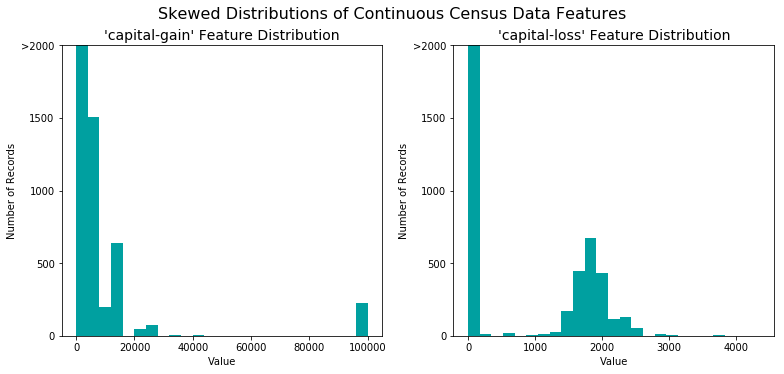

In [32]:
# Visualize skewed continuous features of original data
vs.distribution(features_raw)

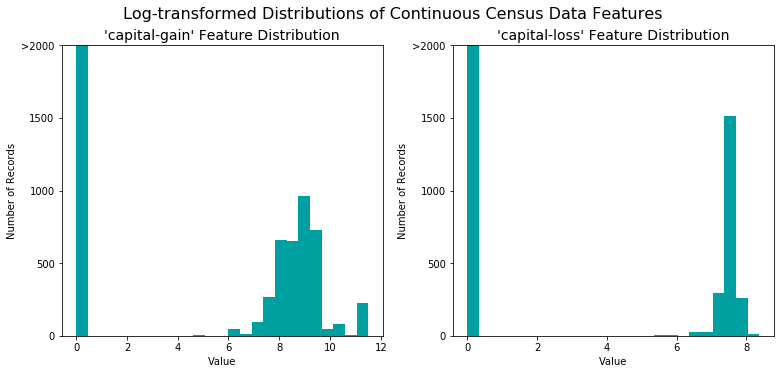

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = features_raw.copy()
features_log_transformed[skewed] = features_log_transformed[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

In [33]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


In [34]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = [0 if x == '<=50K' else 1 for x in income_raw]

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data

In [35]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance

### Question 1 - Naive Predictor Performace

In [36]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
# accuracy == number correctly predicted out of total records; if we predict `>50K`, those are the ones we will get right
accuracy = n_greater_50k / n_records
recall = n_greater_50k/(n_greater_50k + 0)  # if we predict all `>50K`, we will recall 100%; 0 false negatives because we won't predict any negatives
precision = n_greater_50k/(n_greater_50k + n_at_most_50k)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore =  (1 + (beta**2)) * (precision * recall) / (((beta**2) * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Question 2 - Model Application

List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**NOTE**: I'm not sure I like the `describe one real-world application` question. It assumes that each algorithm has a specific example where it would necessarily do better than others. The typical example of Naive Bayes might be a spam classifier, but that doesn't mean other algorithms won't out perform it in that use case. A model can be applied to many use-cases and each use-case can have different many different models that will potentially out-perform the typical "example" model used. The strengths/weaknesses questions make more sense, that is how you would approach any scenario.

**Answer: **

#### Logistic Regression

- **Example Application**: Predicting credit risk. It could be that banks have to justify who they approve/deny loans for, and logistic regression is extremely transparent. Logistic also gives a probability statement of the outcome. Therefore, a lower threshold could be set (e.g. if the outcome variable was predicting whether or not a customer would `default`) in order to reduce risk.

- **Strengths**: Fast, gives coefficients (and p-values, etc. similar to Linear Regression) that make the model interpretable, gives probability statement as output. The using the "Z statistic ... the preidctors can be ranked to understand which terms had the largest effect on the model. The logisitc regression model is very popular due to its simplicity and ability to make inferential statements about the model terms." (`Applied Predictive Modeling pg 286`)  

- **Weaknesses**: "This model requires the user to identify effective representations of the predictor data that yeild the best performance." `APL pg 187`. By default, the model captures linear relationships (although changing the underlying data via transformations can mitigate that), and also produces a linear classification boundary.

- **Good Candidate**: I'm not necessarily sure it is a great candidate, I expect it to do worse than Random Forest and Adaboost, but I'm interesting to see how it comes to the ensembles/trees. If the ensembles don't significantly outperform the logistic regression, I might consider diving into SVMs (which seem slower to train with large amounts of data and features). Also, Logistic Regression has higher bias lower variance than inherently found in tree methods so, again, it will be interesting to compare.

#### Random Forest

- **Example Application**: My company uses Random Forest to score sales leads from website signups. Random Forest also gives the ability to see relative feature importance, which we use to understand factors that lead people to become customers.
- **Strengths**: Introduces extra randomness (compared to a regular bagging classifier) by looking at a rando subset of features, which tradesa higher bias for a lower variance. (Hands on Machine Learning, pg. 191) It's also easy to measure the relative importance of each feature ... "by looking at how much the tree nodes that use that feature reduce impurity on average." (Hands on Machine Learning, pg. 192) Random Forest also comes with the ability to get the 'out-of-bag' (OOB) measure on performance, eliminating the need to use cross-validation in some cases. "The resulting OOB error is a valid estimate of the test error for the bagged model, since the repsonse for each observation is predicted using only the trees that were not fit using that observation." (Introduction to Statistical Learning pg. 318)
- **Weaknesses**: Unlike Logistic Regression for example, it's difficult to know/report exactly how the model is making decisions.
- **Good Candidate**: There are categorical features in the dataset that have many values (e.g. `education`, `marital-status`, `occupation`, `country`) and the potential to seperate the outcome (`income`) by value or combination of values that could lend themself well to "rules" or "trees".

#### Adaboost

- **Example Application**: Adaboost can be used for small to medium size datasets, on a variety of problems. I'm not sure that given a single example specific to Adaboost really makes sense.
- **Strengths**: "Unlike fiting a single large decision tree to the data, which amounts to fittin gthe data hard and potentially overfitting, the boosting approach instead 'learns slowly'. In general, statistical learning approachs that 'learn slowly' tend to perform well. (Introduction to Statistical Learning pg. 321-322)
- **Weaknesses**: Adaboost cannot be parallelized since each predictor can only be trained after the previous predictor has be trained and evaluatoed. As a result it does not scale as well as bagging." (Hands On Machine Learning pg. 195).
- **Good Candidate**: Same as above, except that it would be good to try out boosting ensembe rather than bagging to see if one lends itself better to the data.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [37]:
# TODO: Import two metrics from sklearn - fbeta_score and 
from sklearn.metrics import fbeta_score, accuracy_score

In [60]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_true=y_train[:300], y_pred=predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_true=y_test, y_pred=predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_true=y_train[:300], y_pred=predictions_train, beta=beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_true=y_test, y_pred=predictions_test, beta=beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [68]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = RandomForestClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = round(len(y_train) * 0.10)
samples_1 = round(len(y_train) * 0.01)

LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.


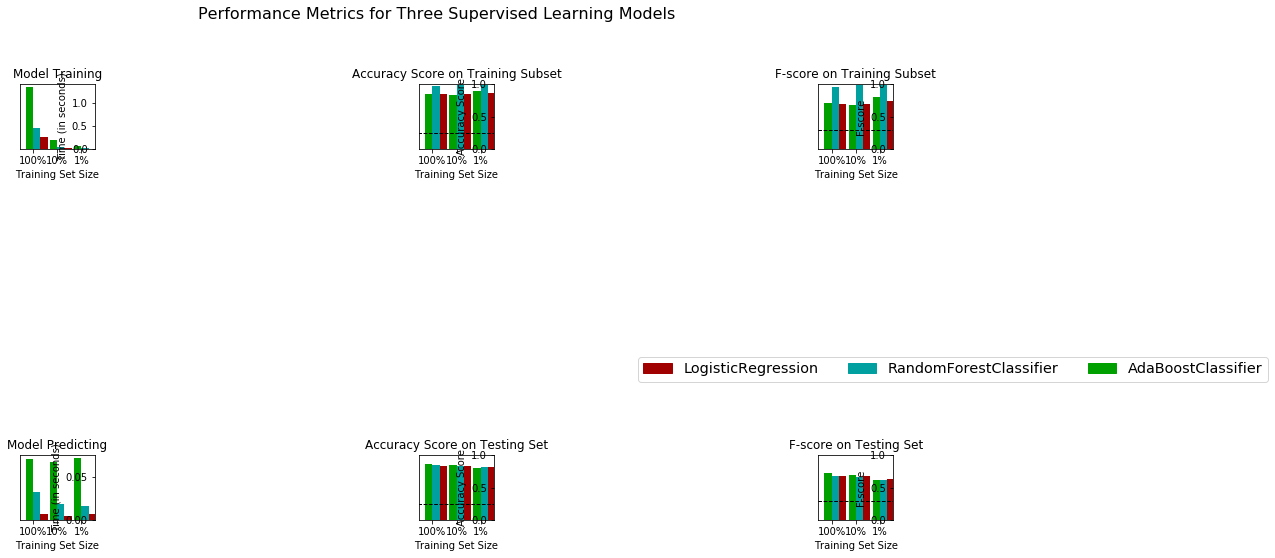

In [69]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [70]:
results

{'LogisticRegression': {0: {'train_time': 0.0025849342346191406,
   'pred_time': 0.006783008575439453,
   'acc_train': 0.86,
   'acc_test': 0.820563847429519,
   'f_train': 0.7386363636363635,
   'f_test': 0.6336913510457886},
  1: {'train_time': 0.02159404754638672,
   'pred_time': 0.004820823669433594,
   'acc_train': 0.8466666666666667,
   'acc_test': 0.8388059701492537,
   'f_train': 0.703125,
   'f_test': 0.6780948247802974},
  2: {'train_time': 0.2632119655609131,
   'pred_time': 0.00671076774597168,
   'acc_train': 0.8466666666666667,
   'acc_test': 0.841901603095633,
   'f_train': 0.6985294117647058,
   'f_test': 0.6831652282416554}},
 'RandomForestClassifier': {0: {'train_time': 0.014184951782226562,
   'pred_time': 0.016051054000854492,
   'acc_train': 0.9833333333333333,
   'acc_test': 0.8133775566611388,
   'f_train': 0.9852941176470588,
   'f_test': 0.6157261995017871},
  1: {'train_time': 0.04069399833679199,
   'pred_time': 0.018699169158935547,
   'acc_train': 0.9966666

In [71]:
["{}: f-beta score on test set (all) {}".format(key, value[2]['f_test']) for key, value in results.items()]

['LogisticRegression: f-beta score on test set (all) 0.6831652282416554',
 'RandomForestClassifier: f-beta score on test set (all) 0.6841786830694767',
 'AdaBoostClassifier: f-beta score on test set (all) 0.7245508982035928']

In [72]:
["{}: accuracy score on test set (all) {}".format(key, value[2]['acc_test']) for key, value in results.items()]

['LogisticRegression: accuracy score on test set (all) 0.841901603095633',
 'RandomForestClassifier: accuracy score on test set (all) 0.8431177446102819',
 'AdaBoostClassifier: accuracy score on test set (all) 0.8576008844665561']

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [75]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [100, 200, 500], 'learning_rate': [0.1, 0.2, 1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=beta)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8664
Final F-score on the testing data: 0.7432


In [74]:
best_clf

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.2, n_estimators=200, random_state=42)

### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8576       |    0.8664       |
| F-score        |      0.7246       |    0.7432       |


**Answer: **

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [ ]:
# TODO: Import a supervised learning model that has 'feature_importances_'


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = None

# TODO: Extract the feature importances using .feature_importances_ 
importances = None

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.